# Unsupervised Learning: K-Means Clustering

## What is Unsupervised Learning?

**Unsupervised learning** is a type of machine learning where we work with data that has **no labels** or target variables. Unlike supervised learning (where we predict a known outcome), unsupervised learning aims to discover hidden patterns, structures, or relationships in the data.

### Key Differences

| Supervised Learning | Unsupervised Learning |
|-------------------|---------------------|
| Data has labels/targets | No labels available |
| Goal: Predict known outcomes | Goal: Discover hidden patterns |

### Common Unsupervised Learning Tasks

1. **Clustering**: Grouping similar data points together
2. **Dimensionality Reduction**: Reducing the number of features while preserving important information
3. **Anomaly Detection**: Identifying unusual patterns or outliers

In the following, we will focus on clustering.

## What is Clustering?

**Clustering** is the task of grouping a set of data points so that points in the same group (cluster) are more similar to each other than to those in other groups. It's like organizing your closet: you might group clothes by color, style, or season without explicit labels.

### Real-World Applications

- **Customer Segmentation**: Group customers by purchasing behavior
- **Image Segmentation**: Group pixels in an image
- **Document Organization**: Group similar documents together
- **Gene Analysis**: Group genes with similar expression patterns

## K-Means Clustering

**K-means** is one of the most popular and widely used clustering algorithms. It partitions data into $K$ clusters, where each cluster is represented by its **centroid** (center point).

### The Goal

Given data points $X = \{x_1, x_2, \ldots, x_n\}$ and a number $K$, find:
- $K$ cluster centers (centroids) $\mu_1, \mu_2, \ldots, \mu_K$
- Cluster assignments $c_1, c_2, \ldots, c_n$ (each $c_i \in \{1, 2, \ldots, K\}$)

such that the **within-cluster sum of squares** is minimized:

$$
\text{Minimize: } \sum_{i=1}^{n} \|x_i - \mu_{c_i}\|^2
$$

This means we want points assigned to clusters to be as close as possible to their cluster centers.

### Lloyd's Algorithm (The Standard K-Means Algorithm)

The most common approach to solve K-means is **Lloyd's algorithm**, which iteratively:

1. **Assignment Step**: Assign each data point to the nearest centroid
2. **Update Step**: Recalculate centroids as the mean of all points in each cluster
3. **Repeat**: Continue until convergence (assignments don't change)

This notebook demonstrates how to implement and visualize K-means clustering from scratch.

In [1]:
%matplotlib inline
import os
import shutil
from typing import Tuple, Optional

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.datasets import make_blobs

# Configure plotting style for consistent, publication-quality figures
sns.set(font_scale=1.2)
sns.set_style("whitegrid", {"grid.linestyle": "--"})
plt.rcParams["figure.figsize"] = (10, 6)

## Creating Synthetic Data

To demonstrate clustering, we'll start by creating synthetic data using `make_blobs`. This function generates Gaussian blobs (clusters) of data points, which is perfect for understanding how clustering algorithms work.

**Note**: In real-world scenarios, you wouldn't know the true labels (which cluster each point belongs to). However, for demonstration purposes, we'll generate data with known labels so we can visualize how well our clustering algorithm performs.


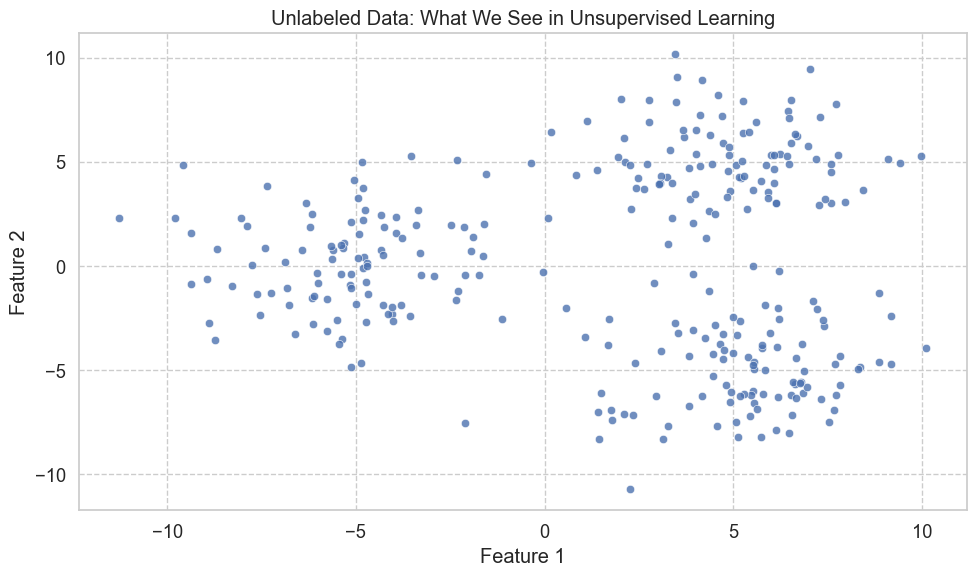

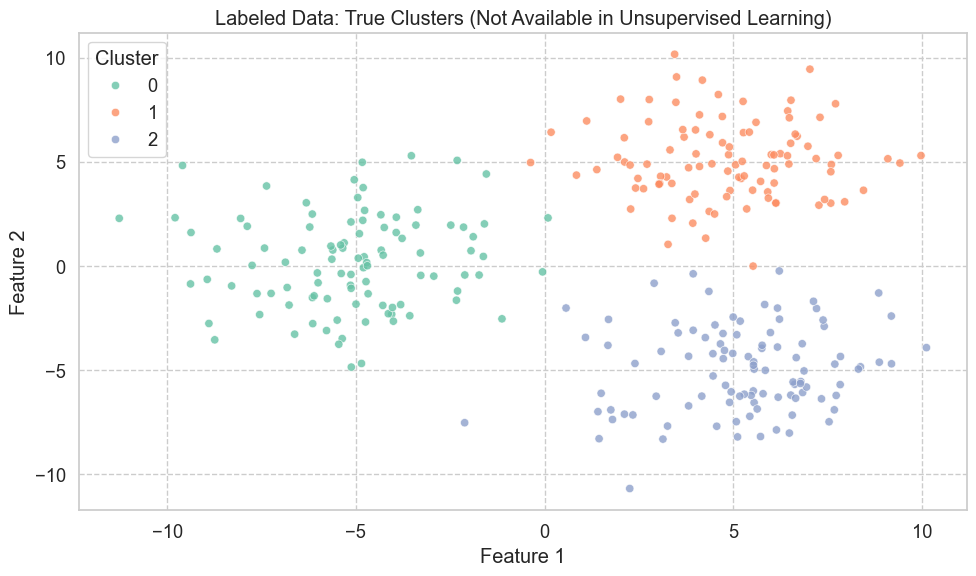

In [2]:
# Generate synthetic data with 3 distinct clusters
# make_blobs creates isotropic Gaussian blobs (clusters) for clustering
X, y = make_blobs(
    n_samples=300,  # Total number of data points
    random_state=8,  # Seed for reproducibility
    centers=[[-5, 0], [5, 5], [5, -5]],  # Coordinates of the 3 cluster centers
    cluster_std=2.0,  # Standard deviation of each cluster (controls spread)
)

# Visualize the data WITHOUT labels (as it would appear in unsupervised learning)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X[:, 0], y=X[:, 1], alpha=0.8)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Unlabeled Data: What We See in Unsupervised Learning")
plt.tight_layout()
plt.show()

# Visualize the data WITH true labels (for comparison - we wouldn't have this in practice)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, alpha=0.8, palette="Set2")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Labeled Data: True Clusters (Not Available in Unsupervised Learning)")
plt.legend(title="Cluster", loc="best")
plt.tight_layout()
plt.show()

## Implementing K-Means from Scratch

Now we'll implement Lloyd's algorithm step by step. This will help us understand exactly how K-means works internally.

### Algorithm Components

Our implementation consists of three main functions:

1. **`find_cluster`**: Assigns each data point to its nearest centroid (Assignment Step)
2. **`find_centers`**: Computes new centroids as the mean of points in each cluster (Update Step)
3. **`kmeans`**: Orchestrates the iterative process until convergence

In [3]:
# Lloyd's algorithm implementation

def find_cluster(X: np.ndarray, centers: np.ndarray) -> np.ndarray:
    """
    Finds the cluster assignment for each data point by assigning it to the nearest centroid.

    This implements the Assignment Step of Lloyd's algorithm. For each point, we compute
    the Euclidean distance to all centroids and assign it to the closest one.

    Args:
        X: Input data array of shape (n_samples, n_features).
        centers: Cluster centroids array of shape (n_clusters, n_features).
                 Each row represents one centroid.

    Returns:
        Cluster assignments array of shape (n_samples,). Each value is an integer
        from 0 to (n_clusters - 1) indicating which cluster the point belongs to.
    """
    all_distances = []  # Will store distances from each point to each centroid

    # Compute squared Euclidean distance from each point to each centroid
    for c in centers:
        # For each centroid, compute distance to all points
        # Using squared distance (avoids taking square root, doesn't change argmin)
        distance = np.sum(np.square(X - c), axis=1)
        all_distances.append(distance)

    # Reshape: each row is a point, each column is a centroid
    # Shape: (n_samples, n_clusters)
    all_distances = np.array(all_distances).T

    # Assign each point to the cluster with minimum distance
    assignments = np.argmin(all_distances, axis=1)
    return assignments


def find_centers(X: np.ndarray, assignments: np.ndarray) -> np.ndarray:
    """
    Computes new cluster centroids as the mean of all points assigned to each cluster.

    This implements the Update Step of Lloyd's algorithm. The new centroid of a cluster
    is simply the average (mean) of all points currently assigned to that cluster.

    Args:
        X: Input data array of shape (n_samples, n_features).
        assignments: Cluster assignments array of shape (n_samples,).
                    Each value indicates which cluster the point belongs to.

    Returns:
        New centroids array of shape (n_clusters, n_features). Each row is the
        mean of all points assigned to that cluster.
    """
    # Get unique cluster indices (some clusters might be empty)
    cluster_index = sorted(np.unique(assignments))
    centers = []

    # Compute mean of points in each cluster
    for k in cluster_index:
        # Select all points assigned to cluster k
        cluster_points = X[assignments == k]
        # Compute mean (centroid) of this cluster
        center = np.mean(cluster_points, axis=0)
        centers.append(list(center))

    centers = np.array(centers)

    # Sanity check: ensure output shape is correct
    assert centers.shape == (len(cluster_index), X.shape[1]), \
        f"Expecting shape ({len(cluster_index)}, {X.shape[1]}), got {centers.shape}."
    return centers


def plot_assignment_and_centers(X: np.ndarray, centers: np.ndarray, assignments: np.ndarray):
    """
    Visualizes cluster assignments and centroids.

    Plots data points colored by their cluster assignment, along with the cluster
    centroids marked with green 'x' markers.

    Args:
        X: Input data array of shape (n_samples, n_features).
        centers: Cluster centroids array of shape (n_clusters, n_features).
        assignments: Cluster assignments array of shape (n_samples,).
    """
    plt.figure(figsize=(10, 6))
    # Plot data points colored by cluster assignment
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=assignments, alpha=0.8, palette="Set2")
    # Plot centroids as green 'x' markers
    sns.scatterplot(
        x=centers[:, 0],
        y=centers[:, 1],
        marker="x",
        color="red",
        s=300,
        linewidth=4,
        label="Centroids"
    )
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title("K-Means Clustering Results")
    plt.legend(title="Cluster", loc="best")
    plt.tight_layout()


def kmeans(
    X: np.ndarray,
    K: int,
    initial_centers: np.ndarray,
    local_dir: Optional[str] = "./kmeans_demo") -> Tuple:
    """
    Performs K-means clustering using Lloyd's algorithm.

    The algorithm iteratively alternates between:
    1. Assigning points to nearest centroids (Assignment Step)
    2. Updating centroids as cluster means (Update Step)

    This continues until convergence (assignments don't change between iterations).

    Args:
        X: Input data array of shape (n_samples, n_features).
        K: Number of clusters to find.
        initial_centers: Initial centroid positions, shape (K, n_features).
        local_dir: Directory to save iteration plots. If None, no plots are saved.

    Returns:
        Tuple containing:
            - centers_history: List of centroid arrays at each iteration
            - assignments_history: List of assignment arrays at each iteration
    """
    # Initialize: assign points randomly (not used in first iteration, but needed for loop)
    assignments_prev = np.random.choice(a=list(range(K)), size=X.shape[0])

    # Start with initial centroids
    centers = initial_centers
    # First assignment step: assign points to initial centroids
    assignments_next = find_cluster(X, centers)

    # Store history for visualization
    centers_history = [centers]
    assignments_history = [assignments_next]

    # Iterative optimization: alternate between assignment and update steps
    iteration = 0
    while not np.allclose(assignments_prev, assignments_next):
        iteration += 1
        # Update Step: compute new centroids based on current assignments
        centers = find_centers(X=X, assignments=assignments_next)

        # Store previous assignments to check for convergence
        assignments_prev = assignments_next.copy()

        # Assignment Step: assign points to new centroids
        assignments_next = find_cluster(X=X, centers=centers)

        # Save state for visualization
        centers_history.append(centers)
        assignments_history.append(assignments_next)

    print(f"Converged after {iteration} iterations")

    # Optionally save visualization of each iteration
    if local_dir:
        try:
            shutil.rmtree(local_dir)
        except OSError:
            print("No directory to remove.")
        os.makedirs(local_dir)

        for i, (centers_iter, assignments_iter) in enumerate(zip(centers_history, assignments_history)):
            plot_assignment_and_centers(X=X, centers=centers_iter, assignments=assignments_iter)
            plt.title(f"Iteration {i}: K-Means Clustering")
            plt.savefig(os.path.join(local_dir, f"iteration_{i}.png"), dpi=100, bbox_inches="tight")
            plt.close()

    return centers_history, assignments_history

## Running K-Means

Now let's run our K-means algorithm on the synthetic data. We'll use $K=3$ clusters since we know the data was generated with 3 clusters.

**Important**: In practice, you often don't know the true number of clusters. Choosing $K$ is a key challenge in K-means clustering.


Converged after 3 iterations


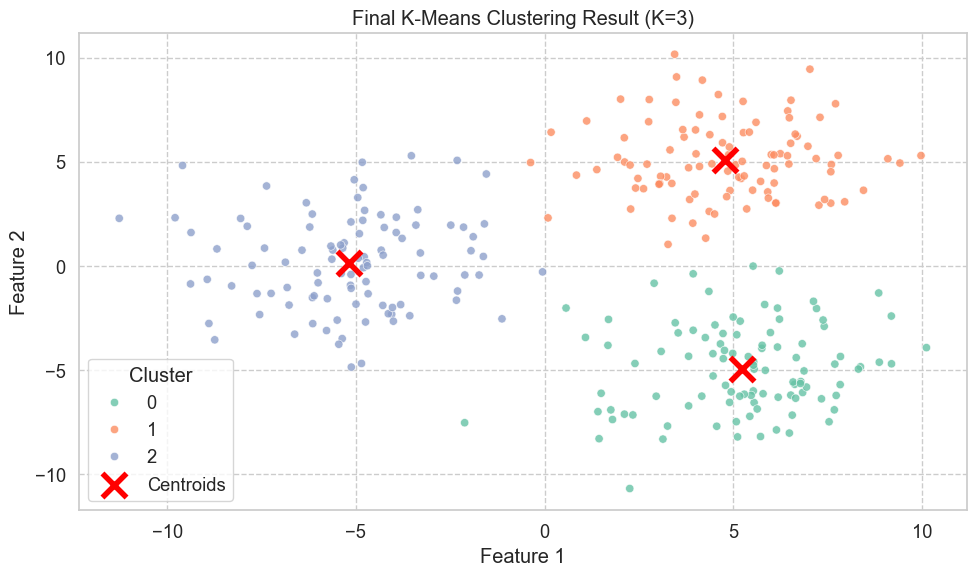

In [4]:
# Set random seed for reproducibility
np.random.seed(42)

K = 3  # Number of clusters (we know this matches the true data structure)
# Initialize centroids randomly from a normal distribution
initial_centers = np.random.normal(size=(K, 2))

# Run K-means clustering
centers_history, assignments_history = kmeans(X=X, K=K, initial_centers=initial_centers)

# Visualize the final result
plot_assignment_and_centers(
    X=X,
    centers=centers_history[-1],
    assignments=assignments_history[-1]
)
plt.title("Final K-Means Clustering Result (K=3)")
plt.show()

# Note: To create an animated GIF showing the iterations:
# 1. Run kmeans with local_dir="./kmeans_demo"
# 2. Use ImageMagick: convert -background white -alpha remove -layers OptimizePlus -delay 50 *.png kmeans.gif

## Choosing the Right Number of Clusters (K)

One of the fundamental challenges in K-means clustering is choosing the **correct number of clusters $K$**. 

### The Problem

- If $K$ is **too small**: Multiple true clusters get merged together
- If $K$ is **too large**: A single true cluster gets split unnecessarily

### Why This Matters

Since K-means is an unsupervised algorithm, we don't have labels to guide us. We must use domain knowledge, visualization, or metrics (like the elbow method or silhouette score) to choose $K$.

### Example: Underfitting with K=3 on 4-Cluster Data

In the example below, we'll show what happens when we choose $K=3$ for data that actually has 4 clusters. The algorithm will force one of the natural clusters to be split or merged, leading to suboptimal results.

### Creating 4-Cluster Data

Let's create a new dataset with 4 distinct clusters to demonstrate the effect of choosing the wrong $K$.


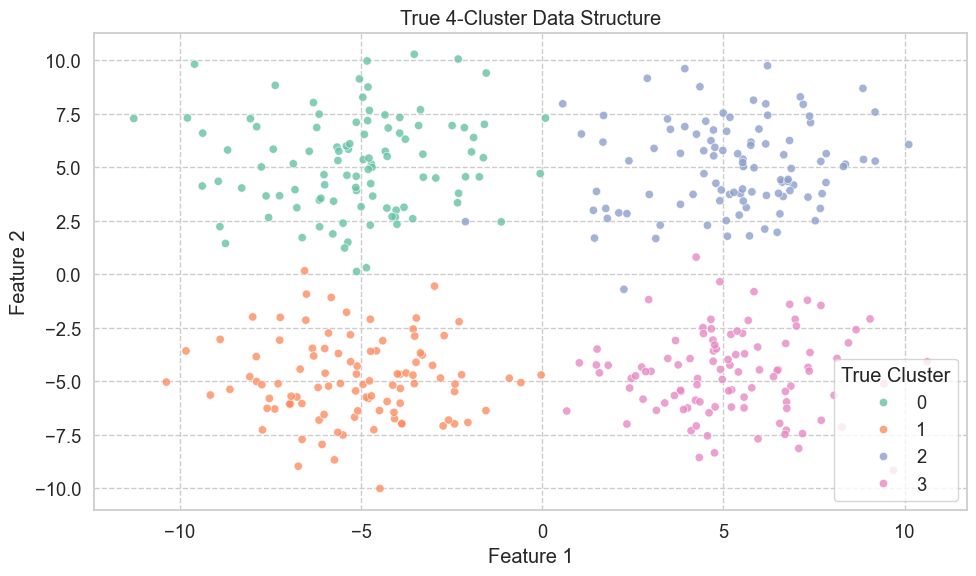

In [5]:
# Generate synthetic data with 4 distinct clusters
np.random.seed(42)

X_4_clusters, y_4_clusters = make_blobs(
    n_samples=400,  # Total number of data points
    random_state=8,  # Seed for reproducibility
    centers=[[-5, 5], [-5, -5], [5, 5], [5, -5]],  # 4 clusters at corners
    cluster_std=2.0,  # Standard deviation of each cluster
)

# Visualize the true 4-cluster structure
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_4_clusters[:, 0], y=X_4_clusters[:, 1], hue=y_4_clusters, alpha=0.8, palette="Set2")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("True 4-Cluster Data Structure")
plt.legend(title="True Cluster", loc="lower right")
plt.tight_layout()
plt.show()

### K-Means with K=3 (Wrong Choice)

When we force $K=3$ on data with 4 natural clusters, K-means will merge some clusters or split others inappropriately. The result depends on the initial centroid positions.


Converged after 2 iterations


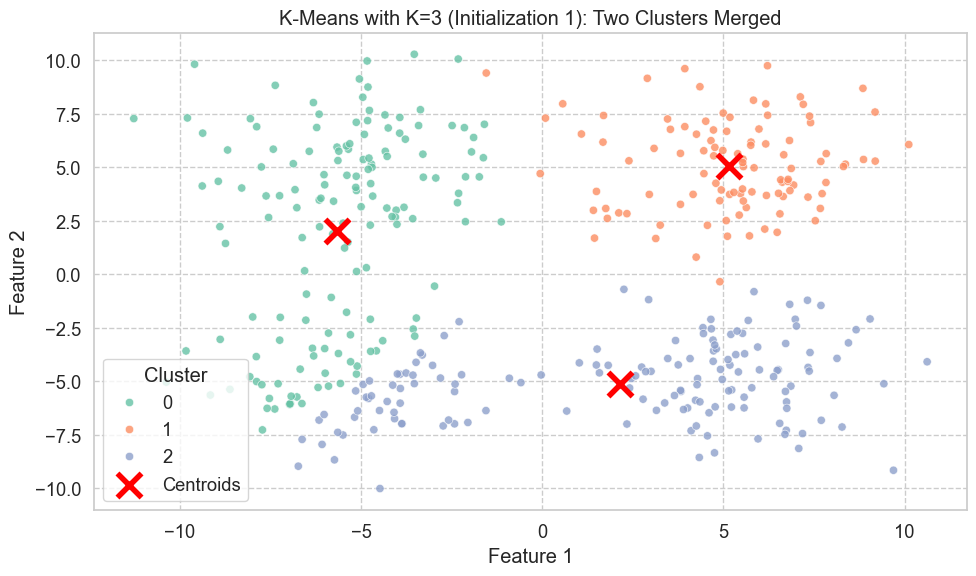

Converged after 4 iterations


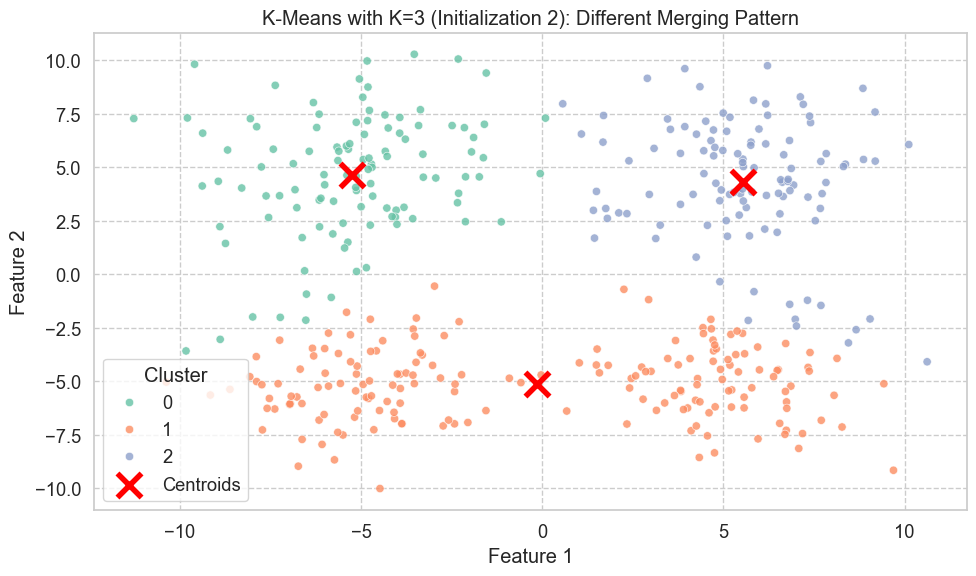

In [6]:
# Try K=3 on 4-cluster data with different initializations
K = 3

# First initialization: start with centroids near 3 of the 4 clusters
centers_history, assignments_history = kmeans(
    X=X_4_clusters,
    K=K,
    initial_centers=[[-5, 5], [5, 5], [5, -5]],  # Missing the [-5, -5] cluster
    local_dir=None
)
plot_assignment_and_centers(
    X=X_4_clusters,
    centers=centers_history[-1],
    assignments=assignments_history[-1]
)
plt.title(f"K-Means with K={K} (Initialization 1): Two Clusters Merged")
plt.show()

# Second initialization: different starting positions
centers_history, assignments_history = kmeans(
    X=X_4_clusters,
    K=K,
    initial_centers=[[-5, 5], [0, -5], [5, 5]],  # Different initial positions
    local_dir=None
)
plot_assignment_and_centers(
    X=X_4_clusters,
    centers=centers_history[-1],
    assignments=assignments_history[-1]
)
plt.title(f"K-Means with K={K} (Initialization 2): Different Merging Pattern")
plt.show()

# Note: Both results show that K=3 is insufficient for this 4-cluster data

### K-Means with Correct K (K=4 and K=5)

Let's see what happens when we choose $K=4$ (correct) and $K=5$ (slightly too many). With $K=4$, we should recover the true cluster structure. With $K=5$, one cluster will be unnecessarily split.


Converged after 4 iterations


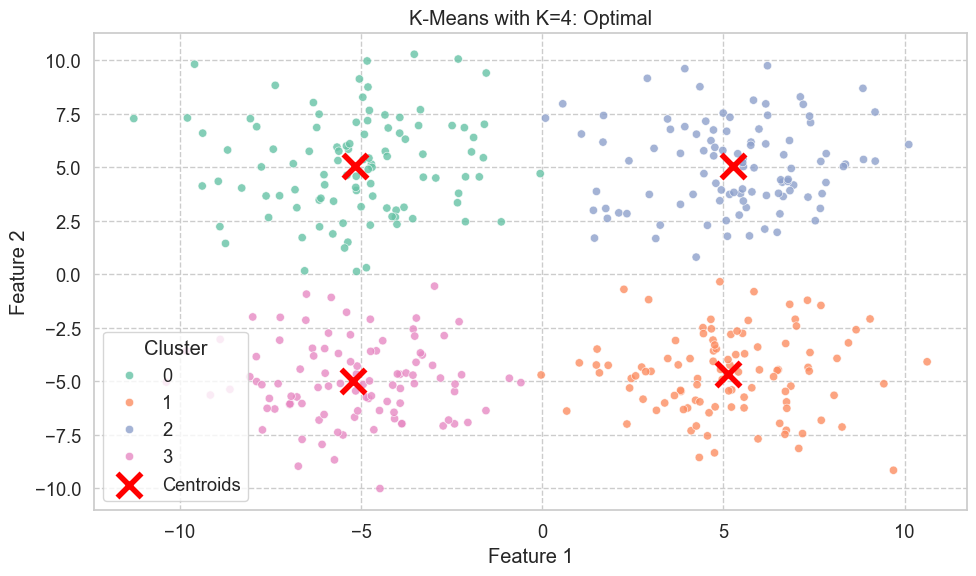

Converged after 6 iterations


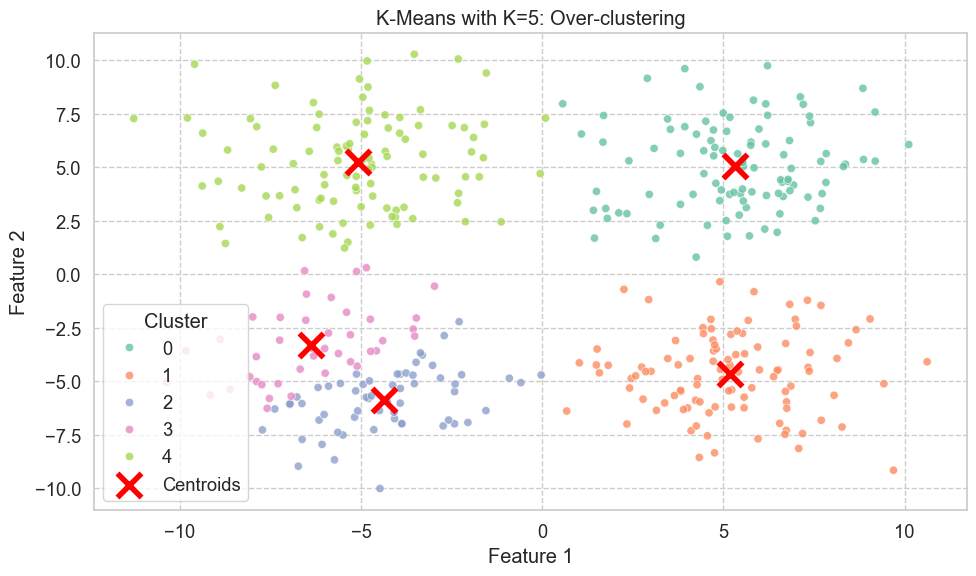

In [7]:
# Try K=4 (correct) and K=5 (too many)
np.random.seed(123)

for K in range(4, 6):
    # Random initialization for each K
    initial_centers = np.random.normal(size=(K, 2))

    centers_history, assignments_history = kmeans(
        X=X_4_clusters,
        K=K,
        initial_centers=initial_centers,
        local_dir=None
    )

    plot_assignment_and_centers(
        X=X_4_clusters,
        centers=centers_history[-1],
        assignments=assignments_history[-1]
    )
    plt.title(f"K-Means with K={K}: {'Optimal' if K == 4 else 'Over-clustering'}")
    plt.show()

# Observation:
# - K=4 matches the true structure well
# - K=5 splits one cluster unnecessarily (over-clustering)